In [6]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import shutil
import pathlib
import re  # Regex
import time
import scipy.io
import matplotlib.pyplot as plt

## Preprocessing

### Fabi implementation

This part will use the train/val/test splits provided in the dataseet.

create the 17 subfolders for each split

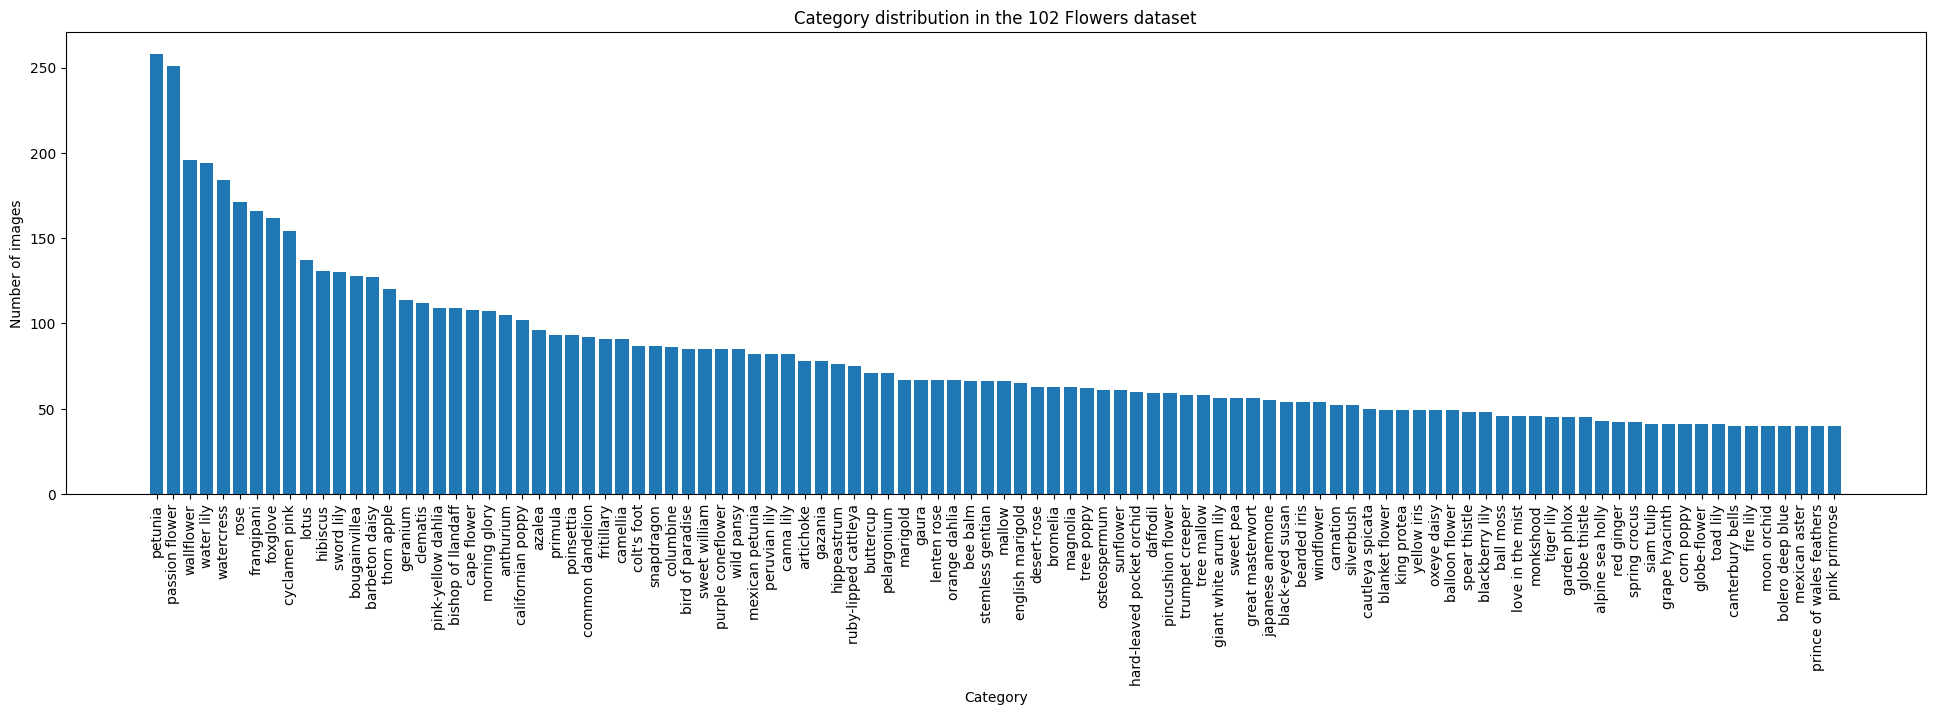

In [12]:
import os
mat = scipy.io.loadmat('./data/102flowers/imagelabels.mat')
mat_labels = mat["labels"][0]

image_size = 224
batch_size = 32
epochs = 300

# list of class labels
with open("102flowers_labels.txt", "r") as f:
    flower_labels = [line.strip() for line in f]

# Count number of images per class
class_count = np.zeros(102)
for i in range(len(mat_labels)):
    class_count[mat_labels[i]-1] += 1

# Sort the data in descending order
sorted_indices = np.argsort(class_count)[::-1]
sorted_x = [flower_labels[i] for i in sorted_indices]
sorted_y = [class_count[i] for i in sorted_indices]

# Plot
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(111)
plt.bar(sorted_x, sorted_y)
plt.xticks(rotation=90)
plt.title("Category distribution in the 102 Flowers dataset")
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.show()

In [5]:
# move the images into the subfolders
def move_images_to_subfolders(path):
    """
    Copy images from `path/jpg` to `path` subfolders train/val/test and their labels.
    """
    src_path = path + "jpg/"
    for filename in os.listdir(src_path):
        if filename.endswith(".jpg"):
            # Get the id of the image from its filename
            
            file_id = int(re.findall(r'\d+', filename)[0])
            # file_id = int(filename[6:-4])

            # Check which split the file belongs to
            if file_id in train_ids:
                split = "train/"
            elif file_id in val_ids:
                split = "val/"
            elif file_id in test_ids:
                split = "test/"
            else:
                print(f"{filename} isn't associated with any splits.")

            # calculate the subfolder to move the image into
            subfolder_id = (file_id-1) // 80  # File ids start from 1, so subtract one. 80 images per label
            subfolder_name = path + split + flower_labels[subfolder_id]

            # move the image into the subfolder
            shutil.copy(os.path.join(src_path, filename), os.path.join(subfolder_name, filename))
    print(f"Images copied successfully to {path} test/train/val subfolders.")


move_images_to_subfolders(path_to_data)

Images copied successfully to data/17flowers/ test/train/val subfolders.


In [10]:
# Split directories
path_to_data = './data/102flowers/'
train_dir = pathlib.Path(path_to_data + "train")
val_dir = pathlib.Path(path_to_data + "val")
test_dir = pathlib.Path(path_to_data + "test")

# Image counts
train_count = len(list(train_dir.glob('*/*.jpg')))
val_count = len(list(val_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))


In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 1020 files belonging to 102 classes.


2023-05-11 09:50:37.562444: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Found 1020 files belonging to 102 classes.
Found 6149 files belonging to 102 classes.


### cc dataset

In [ ]:
path_to_data_cc = "data/17flowers/cc/"

train_dir_cc = pathlib.Path(path_to_data_cc + "train")
val_dir_cc = pathlib.Path(path_to_data_cc + "val")
test_dir_cc = pathlib.Path(path_to_data_cc + "test")

train_count_cc = len(list(train_dir_cc.glob('*/*.jpg')))
val_count_cc = len(list(val_dir_cc.glob('*/*.jpg')))
test_count_cc = len(list(test_dir_cc.glob('*/*.jpg')))


In [ ]:
train_ds_cc = tf.keras.utils.image_dataset_from_directory(
  train_dir_cc,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

val_ds_cc = tf.keras.utils.image_dataset_from_directory(
  val_dir_cc,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

test_ds_cc = tf.keras.utils.image_dataset_from_directory(
  test_dir_cc,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

## Base model function

### base model for cc models

In [ ]:
from keras.applications import VGG16
from processing.grey_world.cc_layers import WhitePatch
from keras import models
from keras import layers
from keras import optimizers
 

def ccModel(cc_layers=None):
    # Load the VGG model
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all the layers except for the last layer: 
    for layer in vgg_model.layers[:-4]:
        layer.trainable = False
    
    # Create the model
    model = models.Sequential()
    model.add(normalization_layer)

    # model.add(tf.keras.layers.Rescaling(1./255))
    if cc_layers != None:
        # Add cc layers
        model.add(cc_layers)
    
    # Add the vgg convolutional base model
    model.add(vgg_model)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(17, activation='softmax'))
    
    # Compile the model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizers.RMSprop(lr=2e-4),
                metrics=['accuracy'])

    # Build the model
    model.build((None, image_size, image_size, 3))
    
    return model

cc model for batch normalization

In [ ]:
def ccBachModel():
    # Load the VGG model
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all the layers except for the last layer: 
    for layer in vgg_model.layers[:-4]:
        layer.trainable = False
    
    # Create the model
    model = models.Sequential()
    model.add(normalization_layer)

    # model.add(tf.keras.layers.Rescaling(1./255))
    model.add(tf.keras.layers.Conv2D(3, 5, padding="same", input_shape=(image_size, image_size, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    # Add the vgg convolutional base model
    model.add(vgg_model)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(17, activation='softmax'))
    
    # Compile the model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizers.RMSprop(lr=2e-4),
                metrics=['accuracy'])

    # Build the model
    model.build((None, image_size, image_size, 3))
    
    return model

In [ ]:
import time

def experiment(model, train_ds, val_ds, test_ds, n_trials=10):
    metrics = {
        "train_time": [],
        "test_time": [],
        "train_acc": [],
        "train_loss": [],
        "val_acc": [],
        "val_loss": [],
        "test_acc": [],
        "test_loss": [],
        "history": []
    }

    for i in range(n_trials):        
        model.compile(
            optimizer=tf.keras.optimizers.RMSprop(lr=2e-4),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

        start_time = time.perf_counter()
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[reduce_lr, early_stop],
            verbose=0)
        end_time = time.perf_counter()
        training_time = end_time - start_time

        start_time = time.perf_counter()
        test_loss, test_acc = model.evaluate(test_ds, verbose=0)
        end_time = time.perf_counter()
        test_time = end_time - start_time

        metrics["train_time"].append(training_time)
        metrics["test_time"].append(test_time)
        metrics["train_acc"].append(history.history["accuracy"][-1])
        metrics["train_loss"].append(history.history["loss"][-1])
        metrics["val_acc"].append(history.history["val_accuracy"][-1])
        metrics["val_loss"].append(history.history["val_loss"][-1])
        metrics["test_acc"].append(test_acc)
        metrics["test_loss"].append(test_loss)
        metrics["history"].append(history)
    return metrics

### Experiments

In [ ]:
from processing.grey_world.cc_layers import GreyWorld, WhitePatch, GreyEdge

grey_world_layer = GreyWorld()
white_patch_layer = WhitePatch()
grey_edge_layer = GreyEdge()

# Create new models
model_base = ccModel()
model_batch = ccBachModel()
model_gw = ccModel(grey_world_layer)
model_ge = ccModel(grey_edge_layer)
model_wp = ccModel(white_patch_layer)
model_fc4 = ccModel()

# Run experiments
n_trials = 1
metrics = {}
metrics["Base"] = experiment(model_base, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["BatchNorm"] = experiment(model_batch, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["GreyWorld"] = experiment(model_gw, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["GreyEdge"] = experiment(model_ge, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["WhitePatch"] = experiment(model_wp, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["FC4"] = experiment(model_fc4, train_ds_cc, val_ds_cc, test_ds_cc, n_trials=n_trials)

### Saving the results

In [ ]:
import pandas as pd
from datetime import datetime
# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

# Export data to Excel sheet
dst_path = f"./out/{timestamp}_experiments_17flowers.xlsx"
with pd.ExcelWriter(dst_path, engine='xlsxwriter',) as writer:
    end_data = pd.concat({k: pd.DataFrame(v) for k, v in metrics.items()}, axis=0, names=["Algorithm", "Trial"])
    end_data.drop("history", axis=1, inplace=True)
    end_data.to_excel(writer, "Final Data", merge_cells=False)

    for k, metric in metrics.items():
        histories = metric["history"]
        algo_data = pd.concat({f"{i}": pd.DataFrame(history.history) for i, history in enumerate(histories)}, axis=1)
        algo_data.to_excel(writer, f"{k} History", merge_cells=False)

print(f"Data saved to {dst_path}")
